In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
# from ROI_extraction import preprocess_image
import cv2
import os
# Set the path to dataset
dataset_path = './images/3regimes'

ids = []
labels = {}
classes = {'excess':1,'normal':0,'insufficient':-1}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path) :
            if filename.endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(class_path, filename) 
                ids.append(img_path)
                labels[img_path]=classes[class_name]

# Set the input image dimensions
img_width, img_height = 104, 104
n_channels = 3

params = {'dim': (img_height,img_width),
          'batch_size': 64,
          'n_classes': 3,
          'n_channels': n_channels,
          'shuffle': False}

# Set the number of classes
num_classes = 3

def correct_gamma(image):
    # Convert image to float and normalize to range 0-1
    image_normalized = image.astype(float) / 255.0

    # Calculate mean R intensity
    meanRimg = np.mean(image_normalized[:, :, 2])  # Image is in BGR format
    
    # Calculate G value
    G = 0.74 * np.exp(-3.97 * meanRimg)
    
    # Apply transformation
    transformed_image = np.power(image_normalized, 1 / G)
    img_float32 = np.float32(transformed_image)
    return img_float32

def extract_ROI(original_image):
    # Convert to grayscale
    gray_image = cv2.cvtColor((original_image*255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    # # Apply histogram normalization
    # normalized_image = cv2.equalizeHist(gray_image)
    
    # Apply median filtering
    filtered_image = cv2.medianBlur(gray_image, 5)
    
    # Apply Otsu's thresholding
    _, thresholded_image = cv2.threshold(filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)
    opened_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)

    # Find contours in the processed image
    contours, _ = cv2.findContours(opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    
    # Calculate the moments of the contour
    M = cv2.moments(contour)
    
    # Calculate the center of the contour
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    
    # Calculate the coordinates of the square ROI
    roi_size = img_height
    roi_x = center_x - roi_size // 2
    roi_y = center_y - roi_size // 2
    
    return {'contours':contours,'roi_x':roi_x,'roi_y':roi_y,'roi_size':roi_size}

def data_generation(list_IDs_temp):
    X = []
    y = np.empty((len(list_IDs_temp)), dtype=int)
    for i, ID in enumerate(list_IDs_temp):
        image = cv2.imread(ID)
        img_gamma_correct = correct_gamma(image)
        ROI = extract_ROI(img_gamma_correct)
        ROI = image[ROI['roi_y']:ROI['roi_y']+ROI['roi_size'], ROI['roi_x']:ROI['roi_x']+ROI['roi_size']]
        # ROI = cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY)
        X.append(ROI)
        # Store class
        y[i] = labels[ID]
    X = np.reshape(X,(len(list_IDs_temp),img_width, img_height,params['n_channels']))
    X = X.astype("float32") / 255.0
    return X, keras.utils.to_categorical(y, num_classes=params['n_classes'])


In [2]:
from sklearn.model_selection import train_test_split

X,y = data_generation(ids)

X_train, X_val, y_train, y_val = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=42)

In [3]:
# Define the autoencoder model
input_img = keras.Input(shape=(img_height,img_width,n_channels))

# Encoder Layers
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder Layers
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
decoded = keras.layers.Conv2D(n_channels, (3, 3), activation='sigmoid', padding='same')(x)

# Define the SSIM loss function
def ssim_loss(y_true, y_pred):
    ssim_value = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 1.0 - ssim_value

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss=ssim_loss)

# Train the autoencoder
autoencoder.fit(x=X_train,y=X_train,
                epochs=40)


Epoch 1/20
110/110 [==============================] - 32s 96ms/step - loss: 0.1620
Epoch 2/20
110/110 [==============================] - 10s 90ms/step - loss: 0.0484
Epoch 3/20
110/110 [==============================] - 10s 89ms/step - loss: 0.0368
Epoch 4/20
110/110 [==============================] - 10s 88ms/step - loss: 0.0332
Epoch 5/20
110/110 [==============================] - 10s 88ms/step - loss: 0.0307
Epoch 6/20
110/110 [==============================] - 10s 88ms/step - loss: 0.0294
Epoch 7/20
110/110 [==============================] - 10s 88ms/step - loss: 0.0289
Epoch 8/20
110/110 [==============================] - 10s 88ms/step - loss: 0.0279
Epoch 9/20
110/110 [==============================] - 10s 91ms/step - loss: 0.0276
Epoch 10/20
110/110 [==============================] - 10s 88ms/step - loss: 0.0277
Epoch 11/20
110/110 [==============================] - 10s 88ms/step - loss: 0.0271
Epoch 12/20
110/110 [==============================] - 10s 88ms/step - loss: 0.0267
E

In [5]:
from sklearn.cluster import KMeans

In [6]:
# Extract the deep features
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(X_train)
encoded_imgs = encoded_imgs.reshape(len(encoded_imgs), 13*13*8)

#train clustering algorithm
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(encoded_imgs)

110/110 [==============================] - 1s 5ms/step


d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=0)

In [8]:
encoded_imgs_val = encoder.predict(X_val)
encoded_imgs_val = encoded_imgs_val.reshape(len(encoded_imgs_val), 13*13*8)
predict_val = kmeans.predict(encoded_imgs_val)

47/47 [==============================] - 0s 8ms/step


C:\Users\nrozo\AppData\Local\Temp\ipykernel_14464\1349369665.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_transformed[kmeans.labels_ == i, 0],


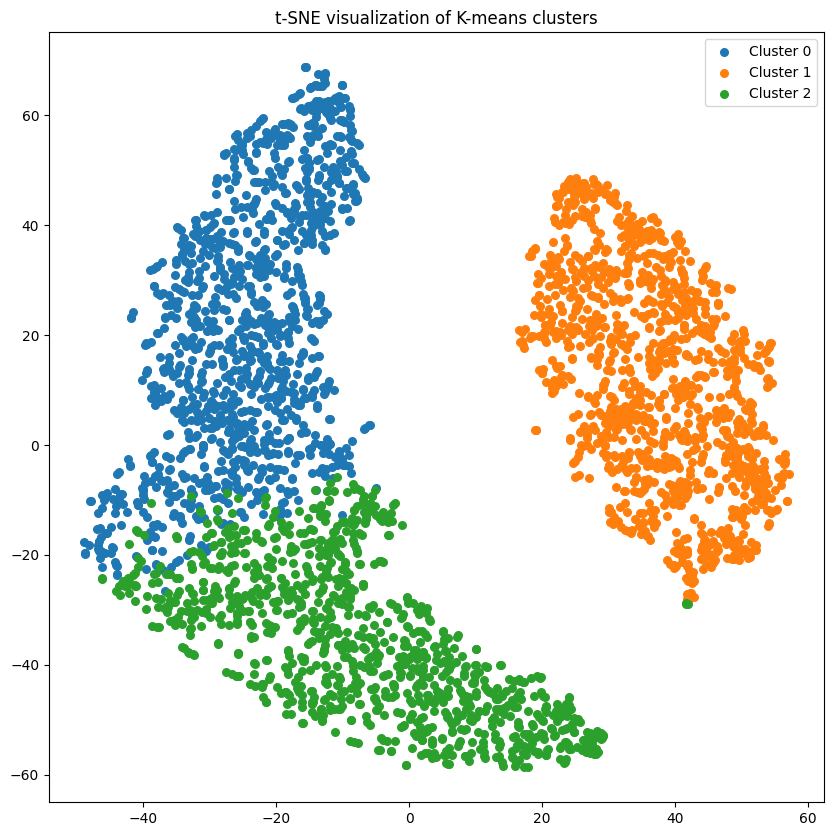

In [10]:
from sklearn.manifold import TSNE
# Use t-SNE to visualize the clusters
tsne = TSNE(n_components=2, random_state=0)
tsne_transformed = tsne.fit_transform(encoded_imgs)

# Plot the clusters
plt.figure(figsize=(10, 10))
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for i in range(3):
    plt.scatter(tsne_transformed[kmeans.labels_ == i, 0],
                tsne_transformed[kmeans.labels_ == i, 1],
                s=30, c=colors[i], label='Cluster %d' % i)
plt.legend()
plt.title('t-SNE visualization of K-means clusters')
plt.show()

In [17]:
for i,prediction in enumerate(predict_val):
    print(prediction)
    print(y_val[i])

0
[0. 1. 0.]
0
[0. 0. 1.]
0
[0. 0. 1.]
0
[0. 1. 0.]
2
[0. 0. 1.]
2
[0. 1. 0.]
0
[0. 1. 0.]
0
[0. 1. 0.]
0
[0. 0. 1.]
1
[1. 0. 0.]
2
[0. 0. 1.]
2
[0. 0. 1.]
1
[1. 0. 0.]
0
[0. 0. 1.]
0
[0. 1. 0.]
2
[0. 0. 1.]
1
[1. 0. 0.]
0
[0. 1. 0.]
1
[1. 0. 0.]
1
[1. 0. 0.]
2
[0. 0. 1.]
0
[0. 0. 1.]
0
[0. 1. 0.]
1
[1. 0. 0.]
1
[1. 0. 0.]
0
[0. 0. 1.]
1
[1. 0. 0.]
1
[1. 0. 0.]
2
[0. 1. 0.]
1
[1. 0. 0.]
2
[0. 0. 1.]
1
[1. 0. 0.]
0
[0. 1. 0.]
2
[0. 1. 0.]
2
[0. 0. 1.]
1
[1. 0. 0.]
0
[0. 0. 1.]
2
[0. 0. 1.]
1
[1. 0. 0.]
0
[0. 0. 1.]
0
[0. 0. 1.]
0
[0. 0. 1.]
1
[1. 0. 0.]
0
[0. 1. 0.]
1
[1. 0. 0.]
2
[0. 0. 1.]
1
[1. 0. 0.]
1
[1. 0. 0.]
1
[1. 0. 0.]
0
[0. 1. 0.]
0
[0. 1. 0.]
0
[0. 1. 0.]
0
[0. 1. 0.]
1
[1. 0. 0.]
1
[1. 0. 0.]
0
[0. 0. 1.]
1
[1. 0. 0.]
2
[0. 0. 1.]
1
[1. 0. 0.]
2
[0. 1. 0.]
2
[0. 0. 1.]
0
[0. 0. 1.]
0
[0. 1. 0.]
1
[1. 0. 0.]
0
[0. 1. 0.]
2
[0. 0. 1.]
2
[0. 1. 0.]
0
[0. 1. 0.]
2
[0. 1. 0.]
2
[0. 1. 0.]
0
[0. 1. 0.]
0
[0. 0. 1.]
0
[0. 1. 0.]
2
[0. 1. 0.]
2
[0. 1. 0.]
0
[0. 1. 0.]
1
[1. 0. 0.]

In [15]:
y_val

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)